In [2]:
%matplotlib inline
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from os import listdir, path
from sbi.analysis import pairplot
# from scipy import stats
import pandas as pd
# import gbi.utils.utils as gbi_utils
from pathlib import Path

import matplotlib.font_manager
path = Path.cwd()
root_path = list(path.parents)[1]
font_files = matplotlib.font_manager.findSystemFonts(fontpaths=[path.parent / "figures" / 'fonts'], fontext='ttf')
matplotlib.font_manager.fontManager.addfont(font_files[0])

# specify matplotlib rc file
plt.style.use(root_path / ".matplotlibrc")
mpl.rcParams['font.family'] = 'Arial'

/home/robin/miniconda3/envs/gbi/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import pickle


def pickle_load(filename):
    with open(filename, "rb") as f:
        loaded = pickle.load(f)
    return loaded

In [4]:
task_name = "two_moons"

inference_dir = root_path.joinpath("gbi_results", "results", "benchmark", "algorithms")

all_infereces = np.sort(listdir(f"{inference_dir}/{task_name}/"))
print(all_infereces)
inference_datetime = all_infereces[2]
# inference_datetime = all_infereces[-1]
all_collections = np.sort(listdir(f"{inference_dir}/{task_name}/{inference_datetime}/posterior_samples_collected/"))
print(all_collections)
collection_datetime = all_collections[-1]
print(f"inference: {inference_datetime}, collection: {collection_datetime}")
df_summaries = pd.read_csv(f"{inference_dir}/{task_name}/{inference_datetime}/posterior_samples_collected/{collection_datetime}/summary_collected.csv", index_col=0)
betas = df_summaries[df_summaries['algorithm']=='GBI']['beta'].unique()

df_summaries = pd.read_csv(f"{inference_dir}/{task_name}/{inference_datetime}/posterior_samples_collected/{collection_datetime}/summary_collected.csv", index_col=0)

ppd_samples = pickle_load(f"{inference_dir}/{task_name}/{inference_datetime}/posterior_samples_collected/{collection_datetime}/posterior_predictives_collected.pkl")

['.DS_Store' '2023_05_03__18_41_31' '2023_05_07__20_08_28'
 '2023_05_11__23_45_10' '2023_08_03__16_02_52' '2023_08_04__15_14_42'
 '2023_08_04__17_17_42' '2023_08_05__16_45_05' '2023_08_05__23_24_44']
['.DS_Store' '2023_05_08__10_33_12' '2023_05_12__17_33_23']
inference: 2023_05_07__20_08_28, collection: 2023_05_12__17_33_23


GT specified
            mean       std
beta                      
10.0    0.080807  0.011984
100.0   0.013271  0.003682
1000.0  0.006012  0.004173
GBI specified
            mean       std
beta                      
10.0    0.080672  0.011132
100.0   0.017053  0.002691
1000.0  0.005972  0.001399
ABC specified
            mean       std
beta                      
10.0    0.085222  0.019983
100.0   0.015504  0.003938
1000.0  0.008378  0.003288
GT misspecified
            mean       std
beta                      
10.0    0.213612  0.116522
100.0   0.122297  0.117444
1000.0  0.114431  0.118683
GBI misspecified
            mean       std
beta                      
10.0    0.215192  0.116151
100.0   0.117114  0.111795
1000.0  0.104415  0.112194
ABC misspecified
            mean       std
beta                      
10.0    0.220744  0.135397
100.0   0.172081  0.169760
1000.0  0.169923  0.168586


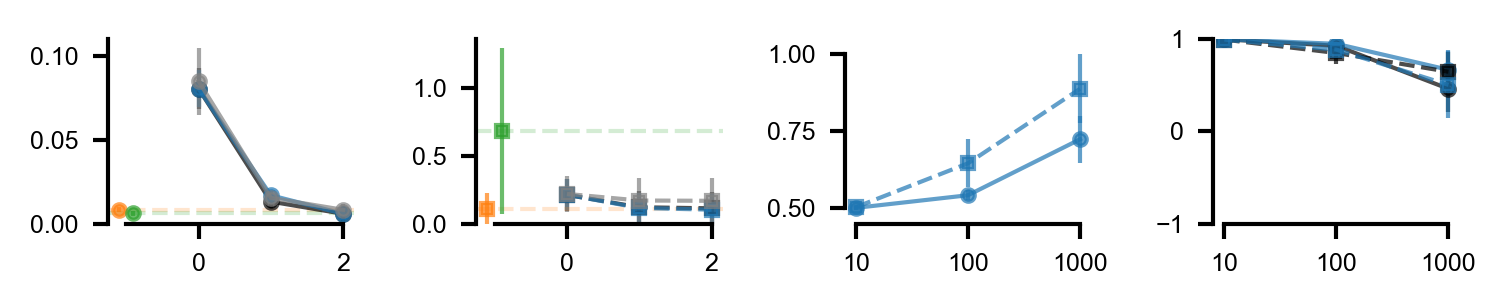

In [5]:
C_DICT = {'GT':'C0', 'GBI':'C1', 'eGBI':'C3', 'ABC':'gray', 'NPE':'C2', 'NLE':'C3'}
df_collapsed = df_summaries.groupby(['algorithm','beta','xo_specified']).describe()
plt.figure(figsize=(5.,1.), dpi=300)
for i_s, is_specified in enumerate(['specified', 'misspecified']):
    plt.subplot(1,4,i_s+1)
    for i_a, alg in enumerate(C_DICT.keys()):
        metric_to_plot = 'dist_samples_mean'
        df_cur = df_collapsed.loc[alg, :, is_specified][metric_to_plot]
        if alg in ['GT', 'GBI', 'ABC']:
            print(alg, is_specified)
            print(df_cur[["mean", "std"]])
            
            plt.errorbar(range(len(df_cur['mean'])), df_cur['mean'].values, yerr=df_cur['std'].values, fmt='-o' if i_s==0 else '--s', color=C_DICT[alg],label=alg, lw=1, alpha=0.7)
        elif alg in ['NLE', 'NPE']:
            plt.errorbar(-1+((i_a%2)-0.5)*0.2, df_cur['mean'].values, yerr=df_cur['std'].values, fmt='o' if i_s==0 else 's', color=C_DICT[alg], label=alg, lw=1, alpha=0.7)
            plt.axhline(df_cur['mean'].values, color=C_DICT[alg], ls='--', alpha=0.2, lw=1)
            # plt.fill_between([-1,3], df_cur['mean'].values+df_cur['std'].values, df_cur['mean'].values-df_cur['std'].values, alpha=0.1, color=f'C{i_a}')

        # plt.xlim([-0.25,2.25])
        
    # plt.xticks([-1,0,1,2], ['N/A']+list(df_collapsed.loc['GBI',:,'specified'].index.values.astype(int)))        
    # if i_s==0: plt.ylabel('mean predictive\nsample distance')        
    plt.gca().spines.bottom.set_bounds((-1, 2))
    plt.ylim(0, None); plt.gca().spines.left.set_bounds((0, plt.ylim()[1]))
    # plt.xlabel('beta'); 
    # plt.title(f'{task_name}: ' + ('well-specified' if i_s==0 else 'misspecified'))        
    
    
plt.subplot(1,4,3)        
for i_s, is_specified in enumerate(['specified', 'misspecified']):
    alg='GBI'
    df_cur = df_collapsed.loc[alg, :, is_specified]['c2st']
    plt.errorbar(range(len(df_cur['mean'])), df_cur['mean'].values, yerr=df_cur['std'].values, fmt='-o' if i_s==0 else '--s', color=C_DICT[alg],label=alg, lw=1, alpha=0.7)

plt.xticks([0,1,2], list(df_collapsed.loc['GBI',:,'specified'].index.values.astype(int)))
# plt.ylabel('corr(GT vs. estimate distance)')
plt.gca().spines.bottom.set_bounds((0, 2))
plt.ylim(.45, 1.05); plt.gca().spines.left.set_bounds((.5, 1))

plt.subplot(1,4,4)        
for i_s, is_specified in enumerate(['specified', 'misspecified']):
    for alg in ['GT', 'GBI']:
        df_cur = df_collapsed.loc[alg, :, is_specified]['r_dist_gt_estimate']
        plt.errorbar(range(len(df_cur['mean'])), df_cur['mean'].values, yerr=df_cur['std'].values, fmt='-o' if i_s==0 else '--s', color=C_DICT[alg],label=alg, lw=1, alpha=0.7)

plt.xticks([0,1,2], list(df_collapsed.loc['GBI',:,'specified'].index.values.astype(int)))
# plt.ylabel('corr(GT vs. estimate distance)')
plt.gca().spines.bottom.set_bounds((0, 2))
plt.ylim(-1, 1); plt.gca().spines.left.set_bounds((-1, 1))

        
# plt.subplot(1,2,2)
    # plt.legend(frameon=False, loc='upper right', bbox_to_anchor=(1.5,1), fontsize=6)
#put legend outside of plot
# plt.legend(frameon=True, loc='upper right', bbox_to_anchor=(1.2,1))
plt.tight_layout()

In [6]:
def load_from_inference(inference_datetime, collection_idx=-1, verbose=False):
    all_collections = np.sort(listdir(f"{inference_dir}/{task_name}/{inference_datetime}/posterior_samples_collected/"))    
    collection_datetime = all_collections[-1]    
    load_dir = f'{inference_dir}/{task_name}/{inference_datetime}/posterior_samples_collected/{collection_datetime}/'
    if verbose:
        print(all_collections)
        print(f"inference: {inference_datetime}, collection: {collection_datetime}")
        print(load_dir)
    df_summaries = pd.read_csv(f"{load_dir}/summary_collected.csv", index_col=0)
    ppd_samples = pickle_load(f"{load_dir}/posterior_predictives_collected.pkl")
    return df_summaries, ppd_samples
    

uniform_1d specified GT
           mean       std
beta                     
4.0    0.094298  0.075798
20.0   0.042757  0.006948
100.0  0.025788  0.000996
uniform_1d specified GBI
           mean       std
beta                     
4.0    0.094360  0.077540
20.0   0.049991  0.027078
100.0  0.027609  0.002308
uniform_1d specified ABC
           mean       std
beta                     
4.0    0.117253  0.044307
20.0   0.062771  0.009891
100.0  0.047176  0.013852
uniform_1d specified NLE_tempered
           mean       std
beta                     
4.0    0.039532  0.004524
20.0   0.050624  0.012942
100.0  0.055622  0.017383
uniform_1d misspecified GT
           mean       std
beta                     
4.0    0.423241  0.158605
20.0   0.142351  0.024234
100.0  0.111522  0.025021
uniform_1d misspecified GBI
           mean       std
beta                     
4.0    0.531265  0.286665
20.0   0.151899  0.036086
100.0  0.108193  0.025069
uniform_1d misspecified ABC
           mean       std
bet

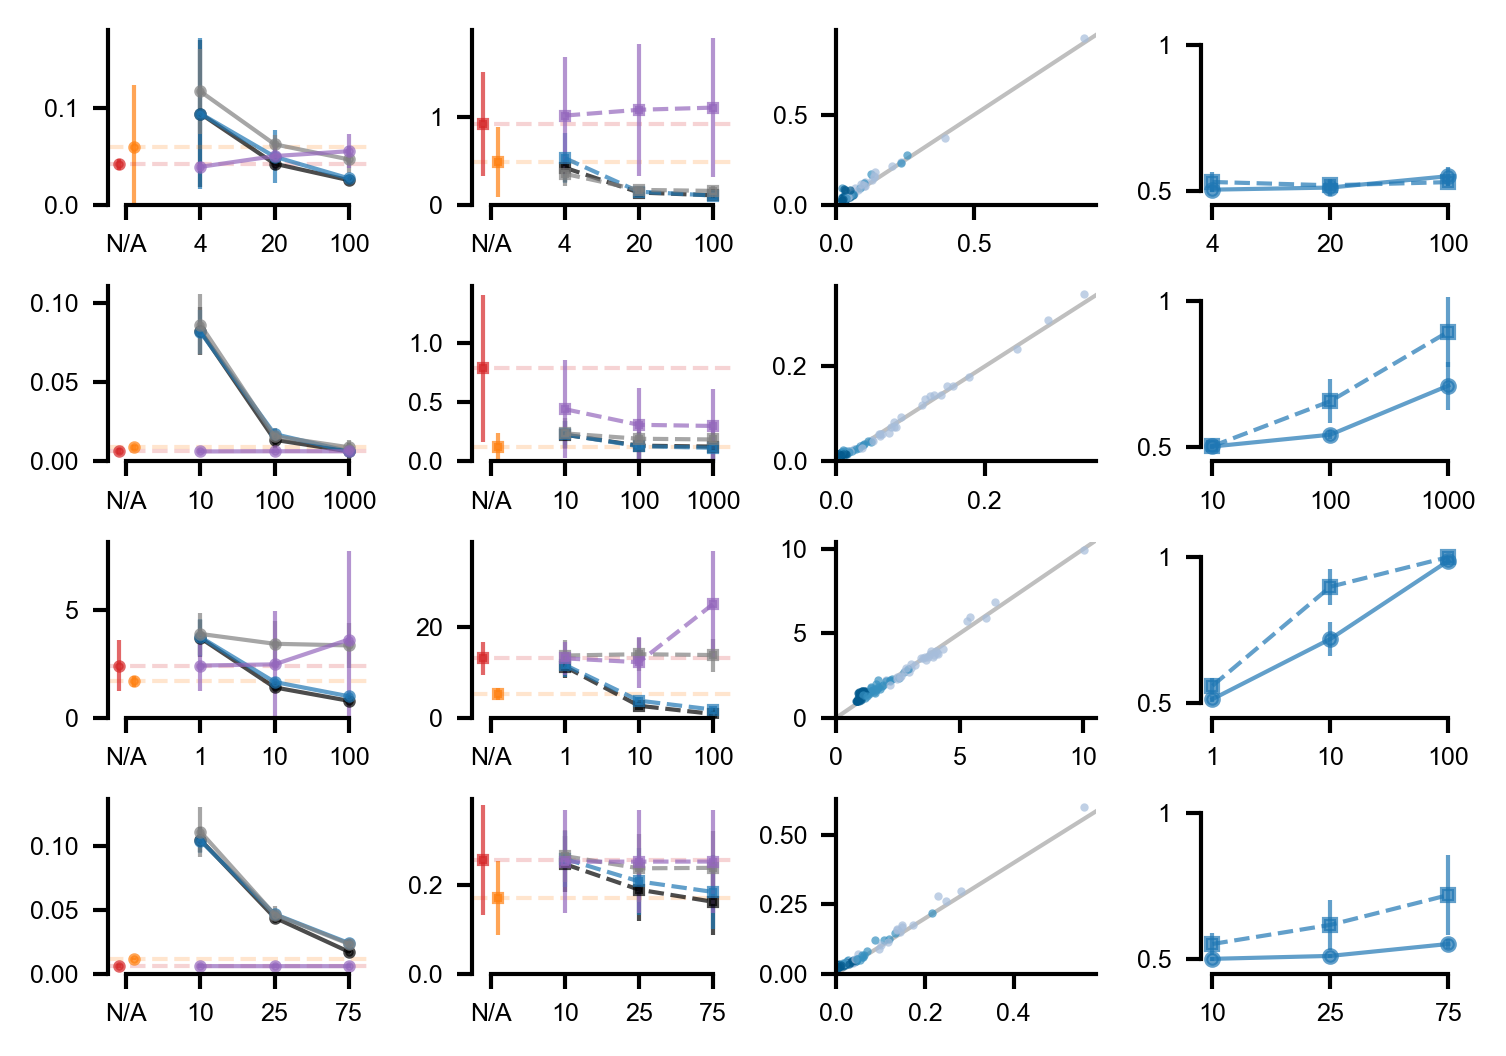

In [7]:
# C_DICT = {'GT':'k', 'GBI':'C0', 'eGBI':'C3', 'ABC':'gray', 'NPE':'C1', 'NLE':'C2'}
C_DICT = {'GT':'C0', 'GBI':'C1', 'ABC':'gray', 'NPE':'C2', 'NLE':'C4', 'NLE_tempered':'C5'}
inference_dir = root_path.joinpath("gbi_results", "results", "benchmark", "algorithms")
plot_tasks = ["uniform_1d", "two_moons", "linear_gaussian", "gaussian_mixture"]
is_known = 'unknown'
with mpl.rc_context(fname=root_path / ".matplotlibrc"):
    plt.figure(figsize=(5.,3.5), dpi=300)
    for i_t, task_name in enumerate(plot_tasks):
        all_inferences = np.sort(listdir(f"{inference_dir}/{task_name}/"))
        # print(all_inferences)
        
        # load full run data
        df_summaries, ppd_samples = load_from_inference(all_inferences[2], -1)
        
        # load extra tempered NLE data
        df_summaries_NLE_tempered, _ = load_from_inference(all_inferences[4], -1)        
        df_summaries = pd.concat((df_summaries,df_summaries_NLE_tempered))

        betas = df_summaries[df_summaries['algorithm']=='GT']['beta'].unique()

        df_summaries.to_csv(f"GBI_results_{task_name}.csv")
        df_collapsed = df_summaries.groupby(['algorithm','beta','xo_specified', 'xo_known']).describe()
        for i_s, is_specified in enumerate(['specified', 'misspecified']):
            plt.subplot(len(plot_tasks),4, 4*i_t+i_s+1)
            for i_a, alg in enumerate(C_DICT.keys()):
                metric_to_plot = 'dist_samples_mean'
                # df_cur = df_collapsed.loc[alg, :, is_specified][metric_to_plot]
                df_cur = df_collapsed.loc[alg, :, is_specified, is_known][metric_to_plot]
                if alg in ['GT', 'GBI', 'ABC', 'eGBI', 'NLE_tempered']:
                    print(task_name, is_specified, alg)
                    print(df_cur[["mean", "std"]])
                    plt.errorbar(range(len(df_cur['mean'])), df_cur['mean'].values, yerr=df_cur['std'].values, fmt='-o' if i_s==0 else '--s', color=C_DICT[alg],label=alg, lw=1, alpha=0.7, markersize=2)
                elif alg in ['NLE', 'NPE']:
                    plt.errorbar(-1+((i_a%2)-0.5)*0.2, df_cur['mean'].values, yerr=df_cur['std'].values, fmt='o' if i_s==0 else 's', color=C_DICT[alg], label=alg, lw=1, alpha=0.7, markersize=2)
                    plt.axhline(df_cur['mean'].values, color=C_DICT[alg], ls='--', alpha=0.2, lw=1)                    
                
                
            # plt.xticks([-1,0,1,2], ['N/A']+list(df_collapsed.loc['GBI',:,'specified'].index.values.astype(int)))
            plt.xticks([-1,0,1,2], ['N/A']+list(df_collapsed.loc['GBI',:,'specified', is_known].index.values.astype(int)))
            # if i_s==0: plt.ylabel('mean predictive\nsample distance')
            # if i_s==0: plt.ylabel(task_name)            
            # if i_s==0:plt.ylabel('L2')
            # plt.gca().get_yaxis().set_label_coords(-0.3,0.5)
            plt.xlim(-1.25, 2.25)
            plt.gca().spines.bottom.set_bounds((-1, 2))
            plt.ylim(0, None); plt.gca().spines.left.set_bounds((0, plt.ylim()[1]))            
            # plt.xlabel('beta'); 
            # plt.title(f'{task_name}: ' + ('well-specified' if i_s==0 else 'misspecified'))        
            
        plt.subplot(len(plot_tasks),4,4*i_t+3)
        ## plot scatter
        colors_gbi = ["#a6bddb", "#3690c0", "#045a8d"]
        n_plot=3        
        for i_xo in range(len(ppd_samples)):
            if (ppd_samples[i_xo][0][1]=='specified') & (ppd_samples[i_xo][0][2]==is_known):
            # if (ppd_samples[i_xo][0][2]=='unknown') & (ppd_samples[i_xo][0][0]<5):
                for i_b in range(len(betas)):
                    beta_str = f"beta_{betas[i_b]:.0f}"
                    samples_cur = ppd_samples[i_xo][2]['GBI'][beta_str]
                    np.random.seed(0)
                    idx_rand=np.random.choice(samples_cur['dist_samples'].shape[0], n_plot, replace=False)
                    plt.plot(samples_cur['dist_gt'].numpy()[idx_rand], samples_cur['dist_estimate'].numpy()[idx_rand],'o', color=colors_gbi[i_b], alpha=0.7, ms=2, mew=0)
                    # plt.plot(samples_cur['dist_gt'].numpy()[idx_rand], samples_cur['dist_estimate'].numpy()[idx_rand],'.' if (ppd_samples[i_xo][0][1]=='specified') else 's', color=colors_gbi[i_b], alpha=0.6, ms=1)
        plt.xlim(0, None); plt.ylim(0, None)
        plt.gca().spines.bottom.set_bounds((0, plt.xlim()[1]))
        plt.gca().spines.left.set_bounds((0, plt.ylim()[1]))    
        plt.plot(plt.xlim(), plt.xlim(), 'k-', alpha=0.25, lw=1, zorder=-1)


        # plot correlations
        # for i_s, is_specified in enumerate(['specified', 'misspecified']):
        #     for alg in ['GBI']:
        #         # df_cur = df_collapsed.loc[alg, :, is_specified]['r_dist_gt_estimate']
        #         df_cur = df_collapsed.loc[alg, :, is_specified, 'unknown']['r_dist_gt_estimate']
        #         plt.errorbar(range(len(df_cur['mean'])), df_cur['mean'].values, yerr=df_cur['std'].values, fmt='-o' if i_s==0 else '--s', color=C_DICT[alg],label=alg, lw=1, alpha=0.7)

        # # plt.xticks([0,1,2], list(df_collapsed.loc['GBI',:,'specified'].index.values.astype(int)))
        # plt.xticks([0,1,2], list(df_collapsed.loc['GBI',:,'specified', 'unknown'].index.values.astype(int)))
        # # plt.ylabel('corr(GT vs. estimate distance)')
        
        # # plt.ylim(-1, 1); plt.gca().spines.left.set_bounds((-1, 1))
        # # plt.yticks([-1,0,1])
        # plt.ylim(0, 1.1); plt.gca().spines.left.set_bounds((0, 1))
        # plt.yticks([0,1])
        # plt.xlim(-.1, 2.1); plt.gca().spines.bottom.set_bounds((0, 2))

        plt.subplot(len(plot_tasks),4,4*i_t+4)        
        for i_s, is_specified in enumerate(['specified', 'misspecified']):
            alg='GBI'
            # df_cur = df_collapsed.loc[alg, :, is_specified]['c2st']
            df_cur = df_collapsed.loc[alg, :, is_specified, is_known]['c2st']
            plt.errorbar(range(len(df_cur['mean'])), df_cur['mean'].values, yerr=df_cur['std'].values, fmt='-o' if i_s==0 else '--s', color=C_DICT[alg],label=alg, lw=1, alpha=0.7)

        # plt.axhline(0.5, color='k', alpha=0.7, lw=1)

        # plt.xticks([0,1,2], list(df_collapsed.loc['GBI',:,'specified'].index.values.astype(int)))
        plt.xticks([0,1,2], list(df_collapsed.loc['GBI',:,'specified', is_known].index.values.astype(int)))        
        plt.yticks([.5,1], ['0.5','1'])
        plt.ylim(.45, 1.05); plt.gca().spines.left.set_bounds((.5, 1))
        plt.xlim(-.1, 2.1); plt.gca().spines.bottom.set_bounds((0, 2))

       

                
        # plt.subplot(1,2,2)
            # plt.legend(frameon=False, loc='upper right', bbox_to_anchor=(1.5,1), fontsize=6)
        #put legend outside of plot
        # plt.legend(frameon=True, loc='upper right', bbox_to_anchor=(1.2,1))
        plt.tight_layout()
        

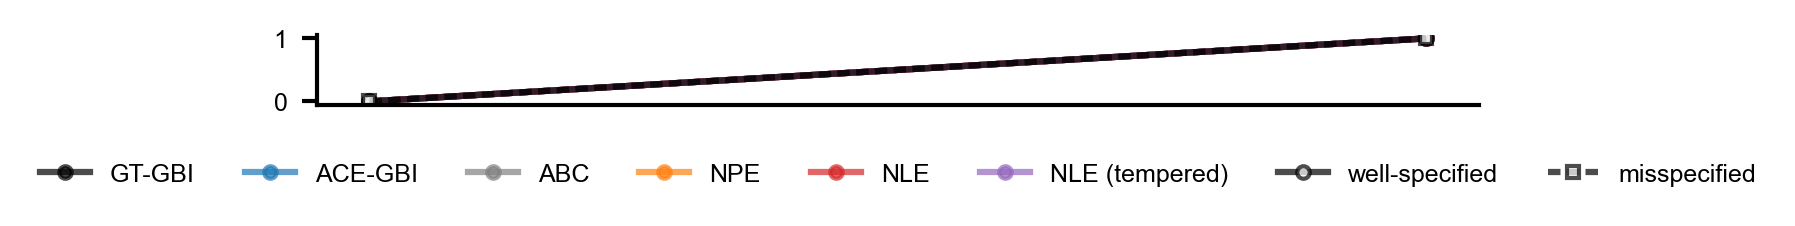

In [8]:
pretty_labels = {"GT": "GT-GBI",
                 "GBI": "ACE-GBI",
                 "ABC": "ABC",
                 "NLE": "NLE",
                 "NLE_tempered": "NLE (tempered)",
                 "NPE": "NPE"}
plt.figure(figsize=(5.,.3), dpi=300)
for i_a, alg in enumerate(C_DICT.keys()):
    plt.plot([0,1], [0,1], 'o-', color=C_DICT[alg], alpha=0.7, label=pretty_labels[alg])

plt.plot([0,1], [0,1], 'ko-', mfc='w', alpha=0.7, label='well-specified')
plt.plot([0,1], [0,1], 'k--s', mfc='w', alpha=0.7, label='misspecified', dashes=[2,1])
plt.xticks([])
# plt.legend(frameon=False, loc='lower center', bbox_to_anchor=(0.5,0))
# put legend horizontally
plt.legend(frameon=False, loc='lower center', bbox_to_anchor=(0.5,-1.5), ncol=8, handlelength=2)
# plt.tight_layout()

['.DS_Store' '2023_05_03__18_41_31' '2023_05_07__20_08_28'
 '2023_05_11__23_45_10' '2023_08_03__16_02_52' '2023_08_04__15_14_42'
 '2023_08_04__17_17_42' '2023_08_05__16_45_05' '2023_08_05__23_24_44']
['.DS_Store' '2023_05_08__10_23_44' '2023_05_12__17_17_20']
inference: 2023_05_07__20_08_28, collection: 2023_05_12__17_17_20
['.DS_Store' '2023_05_03__18_41_31' '2023_05_07__20_08_28'
 '2023_05_11__23_45_10' '2023_08_03__16_02_52' '2023_08_04__15_14_42'
 '2023_08_04__17_17_42' '2023_08_05__16_45_05' '2023_08_05__23_24_44']
['.DS_Store' '2023_05_08__10_33_12' '2023_05_12__17_33_23']
inference: 2023_05_07__20_08_28, collection: 2023_05_12__17_33_23
['.DS_Store' '2023_05_03__18_41_31' '2023_05_07__20_08_28'
 '2023_05_11__23_45_10' '2023_08_03__16_02_52' '2023_08_04__15_14_42'
 '2023_08_04__17_17_42' '2023_08_05__16_45_05' '2023_08_05__23_24_44']
['.DS_Store' '2023_05_08__10_48_02' '2023_05_12__17_57_54']
inference: 2023_05_07__20_08_28, collection: 2023_05_12__17_57_54
['.DS_Store' '2023_05_

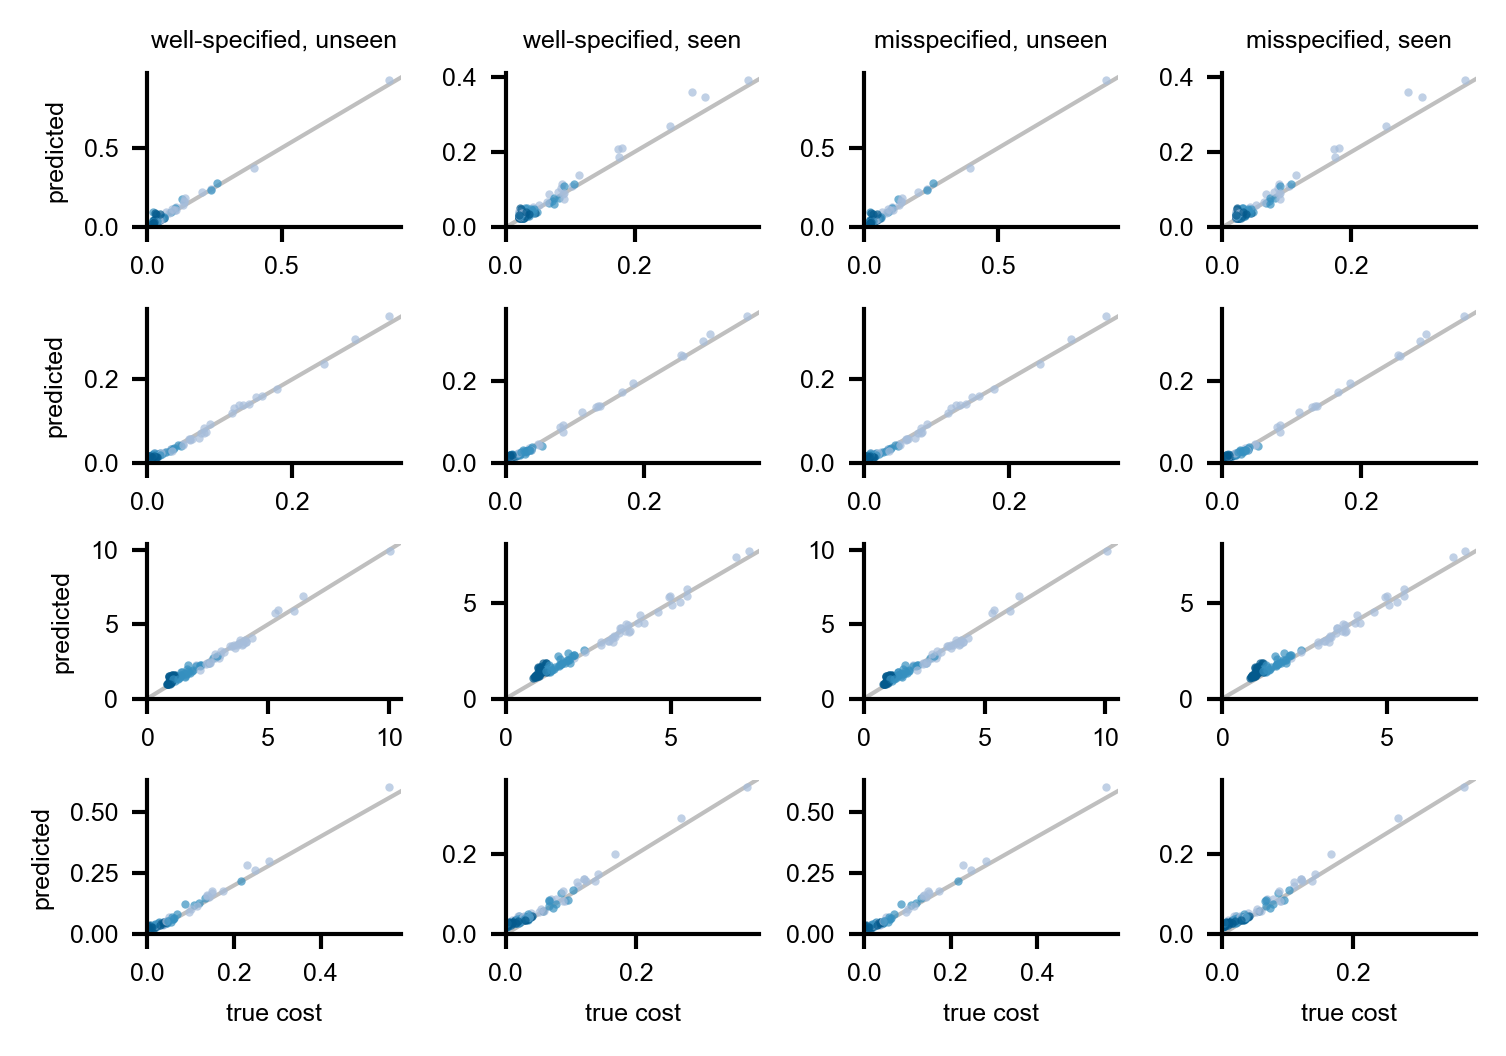

In [9]:
# C_DICT = {'GT':'k', 'GBI':'C0', 'eGBI':'C3', 'ABC':'gray', 'NPE':'C1', 'NLE':'C2'}
C_DICT = {'GT':'C0', 'GBI':'C1', 'ABC':'gray', 'NPE':'C2', 'NLE':'C4'}
inference_dir = root_path.joinpath("gbi_results", "results", "benchmark", "algorithms")
plot_tasks = ["uniform_1d", "two_moons", "linear_gaussian", "gaussian_mixture"]
is_known = 'unknown'
with mpl.rc_context(fname= root_path / ".matplotlibrc"):
    plt.figure(figsize=(5.,3.5), dpi=300)
    for i_t, task_name in enumerate(plot_tasks):
        all_infereces = np.sort(listdir(f"{inference_dir}/{task_name}/"))
        print(all_infereces)
        inference_datetime = all_infereces[2]
        all_collections = np.sort(listdir(f"{inference_dir}/{task_name}/{inference_datetime}/posterior_samples_collected/"))
        print(all_collections)
        collection_datetime = all_collections[-1]
        print(f"inference: {inference_datetime}, collection: {collection_datetime}")
        df_summaries = pd.read_csv(f"{inference_dir}/{task_name}/{inference_datetime}/posterior_samples_collected/{collection_datetime}/summary_collected.csv", index_col=0)
        ppd_samples = pickle_load(f"{inference_dir}/{task_name}/{inference_datetime}/posterior_samples_collected/{collection_datetime}/posterior_predictives_collected.pkl")

        betas = df_summaries[df_summaries['algorithm']=='GT']['beta'].unique()

        df_collapsed = df_summaries.groupby(['algorithm','beta','xo_specified', 'xo_known']).describe()
        
        ctr=0
        for i_s, is_specified in enumerate(['specified', 'misspecified']):
            for i_k, is_known in enumerate(['unknown','known']):
                plt.subplot(len(plot_tasks),4,len(plot_tasks)*i_t+ctr+1)
                ## plot scatter
                colors_gbi = ["#a6bddb", "#3690c0", "#045a8d"]
                n_plot=3        
                for i_xo in range(len(ppd_samples)):
                    if (ppd_samples[i_xo][0][1]=='specified') & (ppd_samples[i_xo][0][2]==is_known):
                    # if (ppd_samples[i_xo][0][2]=='unknown') & (ppd_samples[i_xo][0][0]<5):
                        for i_b in range(len(betas)):
                            beta_str = f"beta_{betas[i_b]:.0f}"
                            samples_cur = ppd_samples[i_xo][2]['GBI'][beta_str]
                            np.random.seed(0)
                            idx_rand=np.random.choice(samples_cur['dist_samples'].shape[0], n_plot, replace=False)
                            plt.plot(samples_cur['dist_gt'].numpy()[idx_rand], samples_cur['dist_estimate'].numpy()[idx_rand],'o', color=colors_gbi[i_b], alpha=0.7, ms=2, mew=0)
                            # plt.plot(samples_cur['dist_gt'].numpy()[idx_rand], samples_cur['dist_estimate'].numpy()[idx_rand],'.' if (ppd_samples[i_xo][0][1]=='specified') else 's', color=colors_gbi[i_b], alpha=0.6, ms=1)
                plt.xlim(0, None); plt.ylim(0, None)
                plt.gca().spines.bottom.set_bounds((0, plt.xlim()[1]))
                plt.gca().spines.left.set_bounds((0, plt.ylim()[1]))    
                plt.plot(plt.xlim(), plt.xlim(), 'k-', alpha=0.25, lw=1, zorder=-1)
                
                if i_t==0: plt.title(('well-specified' if i_s==0 else 'misspecified') + ', ' + ('unseen' if i_k==0 else 'seen'))
                if i_t==3: plt.xlabel('true cost')
                if ctr==0: plt.ylabel('predicted')
                
                ctr+=1


        
        plt.tight_layout()
        

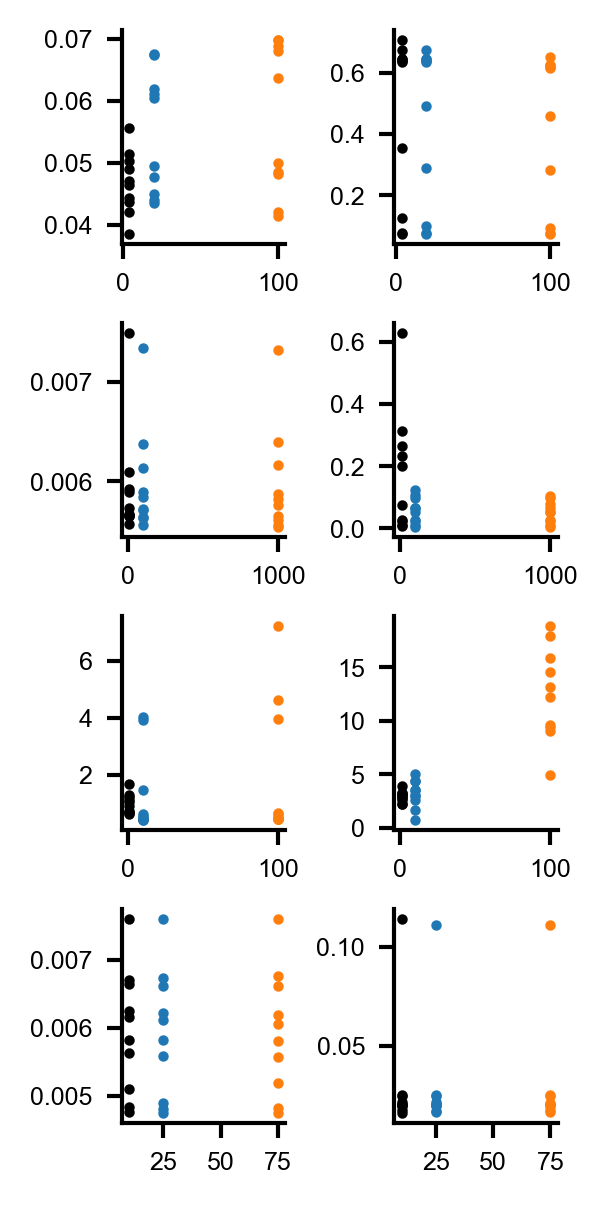

In [10]:
# df_summaries_NLE_tempered

with mpl.rc_context(fname= root_path / ".matplotlibrc"):
    plt.figure(figsize=(2,4), dpi=300)
    for i_t, task_name in enumerate(plot_tasks):
        all_inferences = np.sort(listdir(f"{inference_dir}/{task_name}/"))        
        # load extra tempered NLE data
        df_summaries_NLE_tempered, _ = load_from_inference(all_inferences[4], -1)
        for i_g, g in df_summaries_NLE_tempered.groupby(['algorithm','beta','xo_specified', 'xo_known']):
            for i_s, is_specified in enumerate(['specified', 'misspecified']):
                if i_g[0]=='NLE_tempered':
                    # print(g.loc['NLE_tempered', :, is_specified, is_known])
                    # print(g)
                    # print(g['beta'].values, g[(g['xo_known']=='unknown') & (g['xo_specified']==is_specified)]['dist_samples_mean'].values)
                    plt.subplot(4,2,i_t*2+i_s+1)
                    if ((g['xo_known']=='unknown') & (g['xo_specified']==is_specified)).all():
                        plt.plot(g['beta'].values, g[(g['xo_known']=='unknown') & (g['xo_specified']==is_specified)]['dist_samples_std'].values, '.')

plt.tight_layout()

['.DS_Store' '2023_05_03__18_41_31' '2023_05_07__20_08_28'
 '2023_05_11__23_45_10' '2023_08_03__16_02_52' '2023_08_04__15_14_42'
 '2023_08_04__17_17_42' '2023_08_05__16_45_05' '2023_08_05__23_24_44']
['.DS_Store' '2023_05_03__18_41_31' '2023_05_07__20_08_28'
 '2023_05_11__23_45_10' '2023_08_03__16_02_52' '2023_08_04__15_14_42'
 '2023_08_04__17_17_42' '2023_08_05__16_45_05' '2023_08_05__23_24_44']
['.DS_Store' '2023_05_03__18_41_31' '2023_05_07__20_08_28'
 '2023_05_11__23_45_10' '2023_08_03__16_02_52' '2023_08_04__15_14_42'
 '2023_08_04__17_17_42' '2023_08_05__16_45_05' '2023_08_05__23_24_44']
['.DS_Store' '2023_05_03__18_41_31' '2023_05_07__20_08_28'
 '2023_05_11__23_45_10' '2023_08_03__16_02_52' '2023_08_04__15_14_42'
 '2023_08_04__17_17_42' '2023_08_05__16_45_05' '2023_08_05__23_24_44']


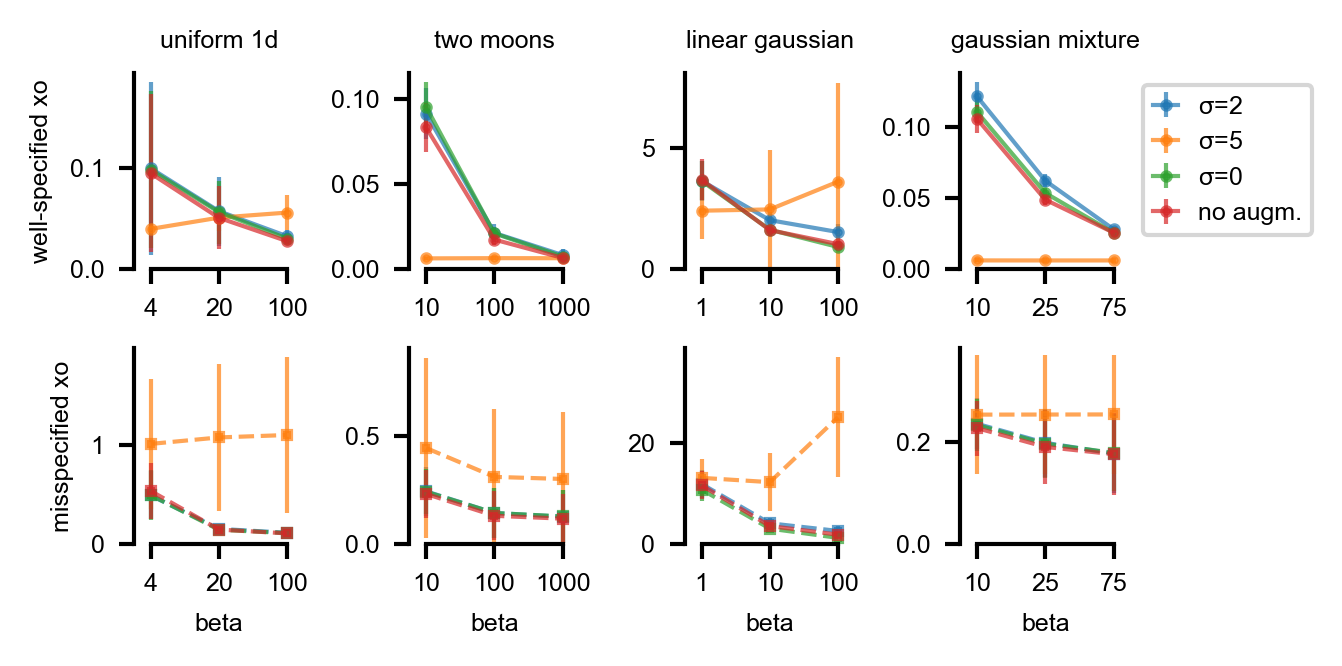

In [11]:
df_summaries_gbi_5s, _ = load_from_inference(all_inferences[5], -1)
df_summaries_gbi_5s


# C_DICT = {'GT':'k', 'GBI':'C0', 'eGBI':'C3', 'ABC':'gray', 'NPE':'C1', 'NLE':'C2'}
C_DICT = {'GBI':'C1', 'GBI_5':'C2', 'GBI_0':'C3', 'GBI_no_obs':'C4'} #10k
# C_DICT = {'GBI':'C1', 'GBI_no_obs':'C4'} #1k

inference_dir = root_path.joinpath("gbi_results", "results", "benchmark", "algorithms")
plot_tasks = ["uniform_1d", "two_moons", "linear_gaussian", "gaussian_mixture"]
is_known = 'unknown'
with mpl.rc_context(fname = root_path / ".matplotlibrc"):
    plt.figure(figsize=(4.5,2.2), dpi=300)
    for i_t, task_name in enumerate(plot_tasks):
        all_inferences = np.sort(listdir(f"{inference_dir}/{task_name}/"))
        print(all_inferences)
        
        # load 10k data
        df_summaries, ppd_samples = load_from_inference(all_inferences[1], -1)
        df_summaries_gbi_5s, _ = load_from_inference(all_inferences[4], -1)
        df_summaries_gbi_5s['algorithm'] = 'GBI_5'
        df_summaries_gbi_0s, _ = load_from_inference(all_inferences[5], -1)
        df_summaries_gbi_0s['algorithm'] = 'GBI_0'        
        df_summaries_gbi_no_obs, _ = load_from_inference(all_inferences[6], -1)
        df_summaries_gbi_no_obs['algorithm'] = 'GBI_no_obs'
        df_summaries = pd.concat((df_summaries,df_summaries_gbi_5s,df_summaries_gbi_0s, df_summaries_gbi_no_obs))
        
        # # load 1k data
        # df_summaries, ppd_samples = load_from_inference(all_inferences[0], -1)
        # df_summaries_gbi_no_obs, _ = load_from_inference(all_inferences[7], -1)
        # df_summaries_gbi_no_obs['algorithm'] = 'GBI_no_obs'
        # df_summaries = pd.concat((df_summaries, df_summaries_gbi_no_obs))

        betas = df_summaries[df_summaries['algorithm']=='GT']['beta'].unique()
        df_collapsed = df_summaries.groupby(['algorithm','beta','xo_specified', 'xo_known']).describe()    
        for i_s, is_specified in enumerate(['specified', 'misspecified']):
            plt.subplot(2, 4, 4*i_s+i_t+1)
            for i_a, alg in enumerate(C_DICT.keys()):
                metric_to_plot = 'dist_samples_mean'
                df_cur = df_collapsed.loc[alg, :, is_specified, is_known][metric_to_plot]
                if alg in list(C_DICT.keys()):
                    plt.errorbar(range(len(df_cur['mean'])), df_cur['mean'].values, yerr=df_cur['std'].values, fmt='-o' if i_s==0 else '--s', color=C_DICT[alg],label=alg, lw=1, alpha=0.7, markersize=2)
                
                
            plt.xticks([0,1,2], list(df_collapsed.loc['GBI',:,'specified', is_known].index.values.astype(int)))
            if i_t==0: plt.ylabel('well-specified xo' if i_s==0 else 'misspecified xo')
            if i_s==0: plt.title(' '.join(task_name.split('_')))
            if i_s==1: plt.xlabel('beta'); 
            plt.xlim(-.25, 2.25)
            plt.gca().spines.bottom.set_bounds((0, 2))
            plt.ylim(0, None); plt.gca().spines.left.set_bounds((0, plt.ylim()[1]))                   

                
    plt.subplot(2,4,4)
    plt.legend([r'$\sigma$=2', r'$\sigma$=5',r'$\sigma$=0',r'no augm.'], frameon=True, fontsize=6, bbox_to_anchor=(1,1), handlelength=1)
    # plt.legend([r'$\sigma$=2',r'sim only'], frameon=True, fontsize=6, bbox_to_anchor=(1,1), handlelength=1)
    plt.tight_layout()
        

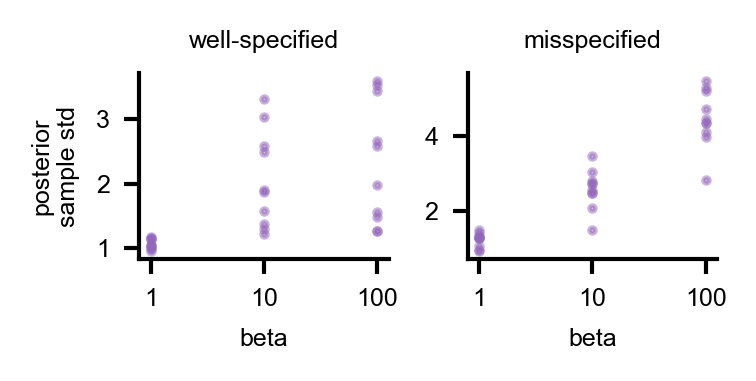

In [12]:
task_name='linear_gaussian'
all_inferences = np.sort(listdir(f"{inference_dir}/{task_name}/"))
df_summaries_tnle, ppd_samples_tnle = load_from_inference(all_inferences[4], -1)
betas = ppd_samples_tnle[0][2]['NLE_tempered'].keys()
with mpl.rc_context(fname=root_path / ".matplotlibrc"):
    plt.figure(figsize=(2.5,1.25), dpi=300)
    for i_x in range(40):
        for i_b, beta in enumerate(betas):
            if ppd_samples_tnle[i_x][0][2]=='unknown':
                if ppd_samples_tnle[i_x][0][1]=='specified':
                    plt.subplot(1,2,1)
                else:
                    plt.subplot(1,2,2)
                plt.plot(i_b, ppd_samples_tnle[i_x][2]['NLE_tempered'][beta]['theta'].std().item(), '.C5', alpha=0.5)                
        
    plt.subplot(1,2,1)
    plt.ylabel('posterior\nsample std')
    plt.xlabel('beta');plt.xticks([0,1,2], [b.split('_')[1] for b in betas])
    plt.title('well-specified')
    
    plt.subplot(1,2,2)
    plt.xlabel('beta');plt.xticks([0,1,2], [b.split('_')[1] for b in betas])
    plt.title('misspecified')
        
    plt.tight_layout()

KeyError: 'GBI_5'

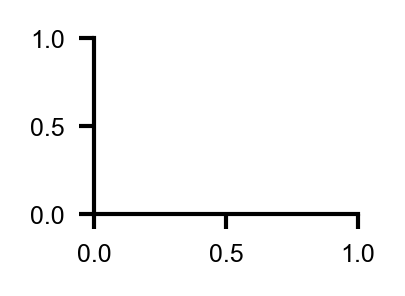

In [13]:
with mpl.rc_context(fname=root_path / ".matplotlibrc"):
    plt.figure(figsize=(2.5,3.5), dpi=300)
    for i_t, task_name in enumerate(plot_tasks):
        all_inferences = np.sort(listdir(f"{inference_dir}/{task_name}/"))

        # load full run data
        df_summaries, ppd_samples = load_from_inference(all_inferences[2], -1)
            
        # load extra tempered NLE data
        df_summaries_NLE_tempered, _ = load_from_inference(all_inferences[4], -1)        
        df_summaries = pd.concat((df_summaries,df_summaries_NLE_tempered))

        df_collapsed = df_summaries.groupby(['algorithm','beta','xo_specified', 'xo_known']).describe()
        for i_s, is_specified in enumerate(['specified', 'misspecified']):
            plt.subplot(len(plot_tasks),2,2*i_t+i_s+1)
            for i_a, alg in enumerate(C_DICT.keys()):
                metric_to_plot = 'dist_samples_mean'
                # df_cur = df_collapsed.loc[alg, :, is_specified][metric_to_plot]
                df_cur_x = df_collapsed.loc[alg, :, is_specified, is_known].index
                df_cur_y = df_collapsed.loc[alg, :, is_specified, is_known]['dist_samples_std']
                if alg in ['NLE_tempered']:
                    plt.plot(df_cur_x.values, df_cur_y['mean'].values, '-o' if i_s==0 else '--s', color=C_DICT[alg],label=alg, lw=1, alpha=0.7, markersize=2)
                #     plt.errorbar(range(len(df_cur['mean'])), df_cur['mean'].values, yerr=df_cur['std'].values, fmt='-o' if i_s==0 else '--s', color=C_DICT[alg],label=alg, lw=1, alpha=0.7, markersize=2)
                # elif alg in ['NLE', 'NPE']:
                #     plt.errorbar(-1+((i_a%2)-0.5)*0.2, df_cur['mean'].values, yerr=df_cur['std'].values, fmt='o' if i_s==0 else 's', color=C_DICT[alg], label=alg, lw=1, alpha=0.7, markersize=2)
                #     plt.axhline(df_cur['mean'].values, color=C_DICT[alg], ls='--', alpha=0.2, lw=1)       

        plt.tight_layout()

In [ ]:
task_name = "gaussian_mixture"
inference_dir = root_path.joinpath("gbi_results", "results", "benchmark", "algorithms")
print(np.sort(listdir(f"{inference_dir}/{task_name}/")))
inference_datetime = np.sort(listdir(f"{inference_dir}/{task_name}/"))[-1]
print(inference_datetime)
collection_datetime=np.sort(listdir(f"{inference_dir}/{task_name}/{inference_datetime}/posterior_samples_collected/"))[-1]
df_summaries = pd.read_csv(f"{inference_dir}/{task_name}/{inference_datetime}/posterior_samples_collected/{collection_datetime}/summary_collected.csv", index_col=0)
# df_summaries = df_summaries.drop(df_summaries[df_summaries['algorithm']=='eGBI'].index)

betas = df_summaries[df_summaries['algorithm']=='GT']['beta'].unique()

['.DS_Store' '2023_05_03__18_41_31' '2023_05_07__20_08_28'
 '2023_05_11__23_45_10' '2023_08_03__16_02_52' '2023_08_04__15_14_42'
 '2023_08_04__17_17_42' '2023_08_05__16_45_05' '2023_08_05__23_24_44']
2023_08_05__23_24_44


In [ ]:
file_path = root_path.joinpath('gbi_results', 'results', 'benchmark', 'algorithms', 'linear_gaussian', '2023_05_07__20_08_28', 'GBI', 'inference.pickle')
inference = pickle_load(file_path)

/home/robin/projects/lab_project/neuralgbi_diffusion/gbi_results/results/benchmark/algorithms/linear_gaussian/2023_05_07__20_08_28/GBI/inference.pickle


ModuleNotFoundError: No module named 'gbi'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


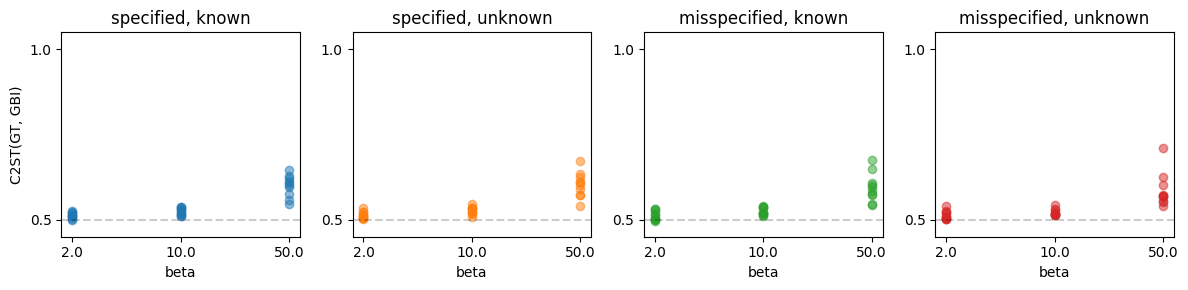

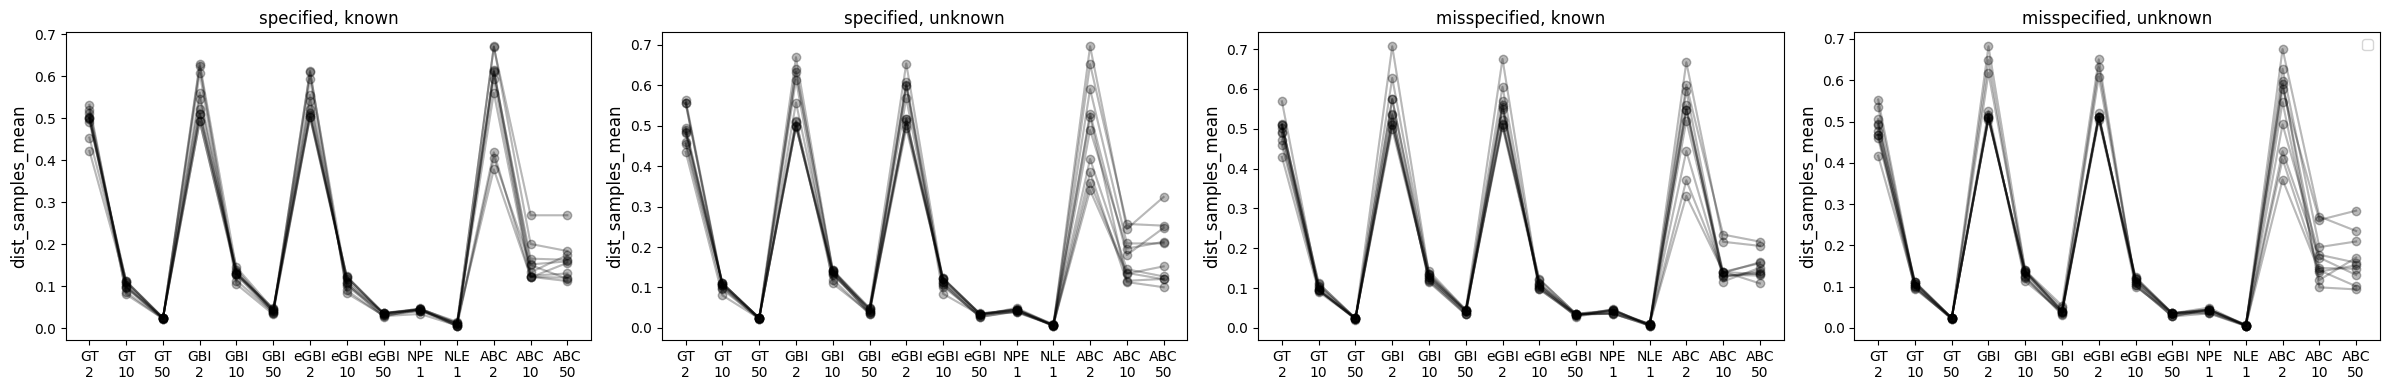

In [ ]:
plt.figure(figsize=(12,3))

for i_s, specified in enumerate(['specified', 'misspecified']):
    for i_k, known in enumerate(['known', 'unknown']):
        plt.subplot(1,4,i_s*2+i_k+1)            
        for xo in range(10):
            df_cur = df_summaries[(df_summaries['algorithm']=="GBI")&(df_summaries['xo_idx']==xo)&(df_summaries['xo_specified']==specified)&(df_summaries['xo_known']==known)]            
            
            plt.plot(range(len(df_cur['beta'])), df_cur['c2st'], 'o', color=f"C{i_s*2+i_k}", alpha=0.5)
            
        plt.xticks(ticks=range(3),labels=df_cur[df_cur['algorithm']=='GBI']['beta'].unique())        
        plt.ylim([0.45,1.05]); plt.yticks([0.5,1])
        plt.axhline(0.5, alpha=0.2, color='k', linestyle='--')
        plt.title(f"{specified}, {known}")
        plt.xlabel('beta')

plt.subplot(1,4,1)
plt.ylabel('C2ST(GT, GBI)')
plt.tight_layout()
metric_to_plot = 'dist_samples_mean'
# metric_to_plot = 'mse_dist_gt_estimate'
# metric_to_plot = 'r_dist_gt_estimate'
plt.figure(figsize=(24,4))
for i_s, specified in enumerate(['specified', 'misspecified']):
    for i_k, known in enumerate(['known', 'unknown']):
        plt.subplot(1,4,i_s*2+i_k+1)            
        for xo in range(10):
            df_cur = df_summaries[(df_summaries['xo_idx']==xo)&(df_summaries['xo_specified']==specified)&(df_summaries['xo_known']==known)]     
            df_cur = df_cur.iloc[[6,7,8,3,4,5, 11,12,13, 10,9,0,1,2]]       
            for i_, i_b in enumerate([3,4,5]):
#                 # GBI GT vs. GBI estimated
#                 plt.plot(df_cur['dist_sample_mean'].iloc[-1], df_cur['dist_sample_mean'].iloc[i_b], 'o', color=f"C{i_}", label=betas[i_] if xo==0 else None, alpha=0.5)
#                 # plt.errorbar(df_cur['dist_sample_mean'].iloc[-1], df_cur['dist_sample_mean'].iloc[i_b], xerr=df_cur['dist_sample_std'].iloc[-1], yerr=df_cur['dist_sample_std'].iloc[i_b], color=f"C{i_}", alpha=0.1)
                
#                 # NPE vs. GBI estimated
#                 plt.plot(df_cur['dist_sample_mean'].iloc[i_b-3], df_cur['dist_sample_mean'].iloc[i_b], '*', color=f"C{i_}", alpha=0.5)

                plt.plot(df_cur[metric_to_plot].values, 'ok-', alpha=0.1)
        plt.xticks(range(len(df_cur)), labels=[f"{row['algorithm']}\n{row['beta']:.0f}" for _, row in df_cur.iterrows()])
        
        # XL = [0,plt.ylim()[1]]
        # plt.plot(XL, XL, 'k--', alpha=0.1)            
        plt.title(f"{specified}, {known}")
        plt.ylabel(metric_to_plot, fontsize=12)
        # plt.ylim(0,df_summaries['dist_sample_mean'].max())
        # plt.xticks(XL);plt.yticks(XL);
        # plt.xlabel('GT/NPE'); plt.ylabel('GBI')
        # plt.xscale('log')
        # plt.yscale('log');

plt.legend()
plt.tight_layout()




# df_summaries[(df_summaries['xo_idx']==xo)&(df_summaries['xo_specified']==specified)&(df_summaries['xo_known']==known)]

In [ ]:
x_o = torch.rand(1,4,5)
x_o.repeat(10, *[1]*len(x_o[0].shape)).shape

torch.Size([10, 4, 5])